In [ ]:
!pip install tensorflow 

In [1]:
!pip install opencv-python matplotlib

     ---------------------------------------- 38.2/38.2 MB 1.7 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import imghdr
from matplotlib import pyplot as plt

In [2]:
i_exts = ['jpeg','jpg','png','bmp']

In [3]:
for folder in os.listdir('images'):
    for image in os.listdir(os.path.join('images', folder)):
        path = os.path.join('images', folder, image)
        try:
            ext = imghdr.what(path)
            if ext not in i_exts:
                os.remove(path)
                print(f'Deleting picture: {path}')
        except Exception as e:
            print(f'Problem with image {path}')

In [4]:
count = 0
images = []
classNumber = []
for x in range(0, 3):
    list_img = os.listdir('images'+'/'+str(count))
    for y in list_img:
        curImg = cv2.imread('images' +"/" + str(count) + "/" + y)
        curImg = tf.image.resize(curImg,(128,128))
        images.append(curImg)
        classNumber.append(count)
    print(f"Importing class {count}")
    count += 1
print(" ")
    
images = np.array(images)
classNumber = np.array(classNumber)

Importing class 0
Importing class 1
Importing class 2
 


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, classNumber, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [6]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1572, 128, 128, 3) (1572,)
(393, 128, 128, 3) (393,)
(219, 128, 128, 3) (219,)


In [7]:
y_train = tf.keras.utils.to_categorical(y_train, 3)
y_val = tf.keras.utils.to_categorical(y_val, 3)

In [8]:
def addNumbers(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha='center')

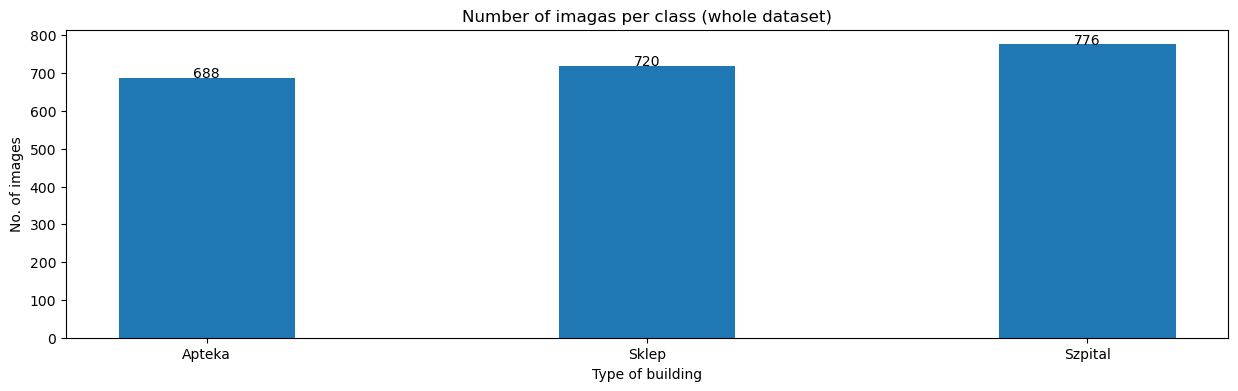

In [9]:
unique, counts = np.unique(classNumber, return_counts=True)
Names = ['Apteka','Sklep','Szpital']
fig = plt.figure(figsize = (15,4))
plt.bar(Names, counts,  width = 0.4)
plt.xlabel("Type of building")
plt.ylabel("No. of images")
plt.title("Number of imagas per class (whole dataset)")
addNumbers(Names,counts)
plt.show()

In [10]:
def preprocesing(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = image/255
    return image

In [11]:
X_train = np.array(list(map(preprocesing,X_train)))
X_val = np.array(list(map(preprocesing,X_val)))
X_test = np.array(list(map(preprocesing,X_test)))                        

In [12]:
print(f'Max value: {X_train.max()}, Min value: {X_train.min()}')
print(f'Max value: {X_val.max()}, Min value: {X_val.min()}')
print(f'Max value: {X_test.max()}, Min value: {X_test.min()}')

Max value: 1.0, Min value: 0.0
Max value: 1.0, Min value: 0.0
Max value: 1.0, Min value: 0.0


In [13]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1572, 128, 128, 3) (1572, 3)
(393, 128, 128, 3) (393, 3)
(219, 128, 128, 3) (219,)


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    
    Conv2D(32, (3, 3), 1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    MaxPooling2D(),
    
    Conv2D(64, (3, 3), 1, activation='relu'),
    MaxPooling2D(),
    
    Conv2D(128, (3, 3), 1, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc = tf.keras.callbacks.ModelCheckpoint(monitor='val_accuracy', mode='max',save_best_only=True, filepath = r"model/best_model.h5", verbose = 1)

In [23]:
history = model.fit(X_train, y_train, batch_size  = 16, epochs = 10, validation_data = (X_val,y_val), callbacks = [mc])

Epoch 1/10
99/99 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9548
Epoch 1: val_accuracy improved from -inf to 0.97710, saving model to model\best_model.h5
99/99 [==============================] - 30s 300ms/step - loss: 0.1905 - accuracy: 0.9548 - val_loss: 0.0642 - val_accuracy: 0.9771
Epoch 2/10
99/99 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9835
Epoch 2: val_accuracy improved from 0.97710 to 0.99237, saving model to model\best_model.h5
99/99 [==============================] - 29s 291ms/step - loss: 0.0592 - accuracy: 0.9835 - val_loss: 0.0407 - val_accuracy: 0.9924
Epoch 3/10
99/99 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9981
Epoch 3: val_accuracy did not improve from 0.99237
99/99 [==============================] - 27s 269ms/step - loss: 0.0078 - accuracy: 0.9981 - val_loss: 0.0368 - val_accuracy: 0.9898
Epoch 4/10
99/99 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9

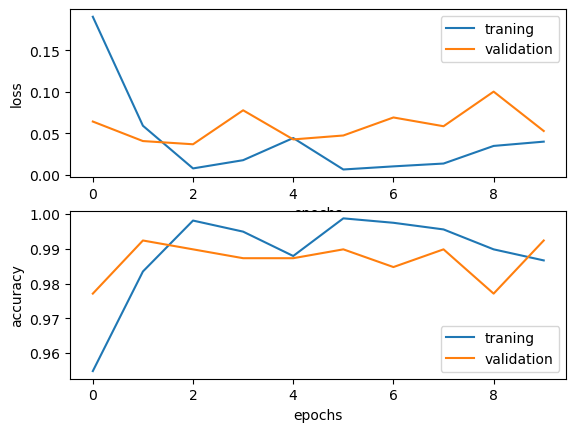

In [24]:
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['traning', 'validation'])
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['traning', 'validation'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [14]:
from tensorflow.keras.models import load_model
model = load_model(r'model/best_model.h5')

In [15]:
predictions = list(np.argmax(model.predict(X_test), axis=-1))

7/7 [==============================] - 1s 87ms/step


In [16]:
def Name(x):
    if x == 0: return 'Apteka'
    elif x == 1: return 'Sklep'
    else: return 'Szpital'

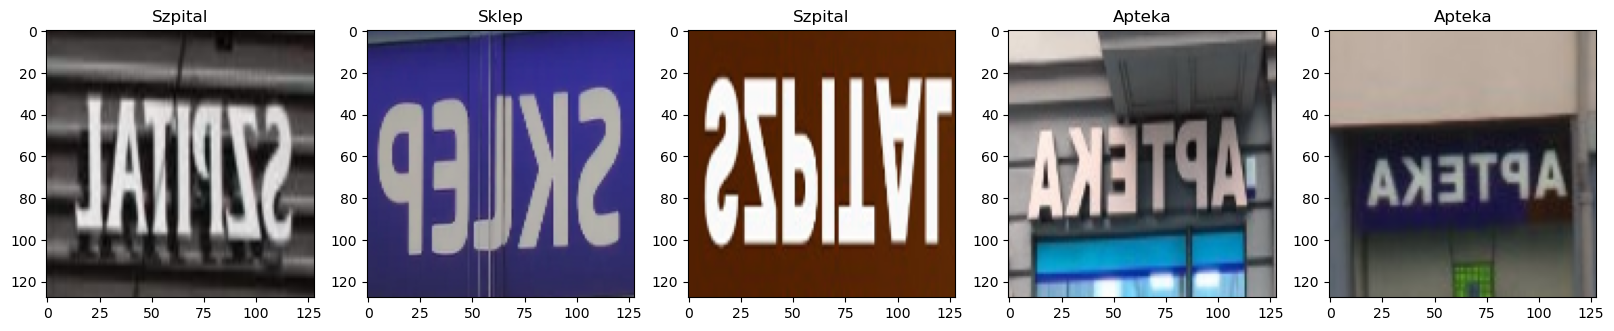

In [17]:
import random
r_nr = random.randint(0,len(X_test)+1)
fig, ax = plt.subplots(ncols = 5, figsize = (20,20))
for i, image in enumerate(X_test[r_nr:r_nr+5]):
    ax[i].imshow(image)
    ax[i].title.set_text(Name(predictions[r_nr+i]))
    

In [18]:
from sklearn.metrics import precision_score,recall_score, balanced_accuracy_score
print(f'Metrics for the model: Precision: {precision_score(y_test, predictions, average = "micro")}, Recall: {recall_score(y_test, predictions, average = "micro")} , Balanced Accuracy: {balanced_accuracy_score(y_test, predictions)}')

Metrics for the model: Precision: 0.9908675799086758, Recall: 0.9908675799086758 , Balanced Accuracy: 0.9901191514094739


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['Apteka','Sklep','Szpital']))

              precision    recall  f1-score   support

      Apteka       0.99      0.99      0.99        74
       Sklep       0.98      0.98      0.98        62
     Szpital       1.00      1.00      1.00        83

    accuracy                           0.99       219
   macro avg       0.99      0.99      0.99       219
weighted avg       0.99      0.99      0.99       219



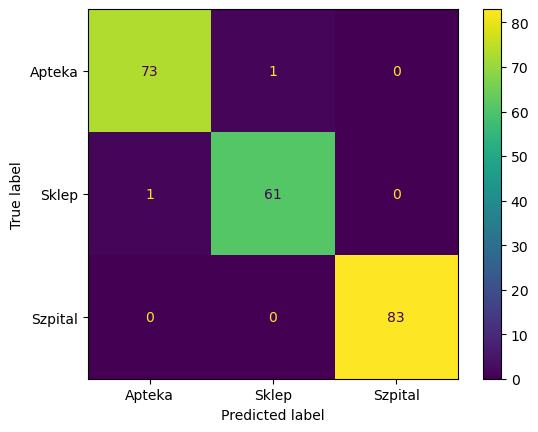

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Apteka','Sklep','Szpital'])
cmd.plot()
plt.show()

In [ ]:
cap = cv2.VideoCapture(0)

while True:
    
    _, image = cap.read()
    
    img = np.asarray(image)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = tf.image.resize(image_col, (128,128))
    
    prediction = model.predict(res_img/255)
    prediction_prob = np.amax(prediction)
    
    if prediction_prob > 0.7:
        cv2.putText(image,  )
    
    
    cv2.imshow('Test Window', image)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()